In [75]:
import torch
import matplotlib.pyplot as plt
# 数据
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

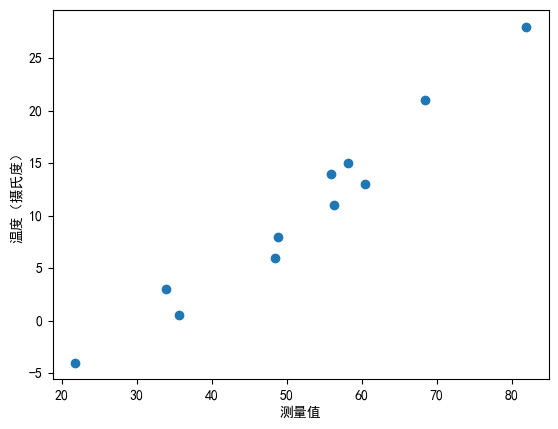

In [96]:
# 数据可视化
%matplotlib inline
plt.rcParams["font.sans-serif"]=["SimHei"]
plt.rcParams["axes.unicode_minus"]=False
plt.plot(t_u.numpy(), t_c.numpy(),'o')
plt.xlabel('测量值')
plt.ylabel('温度（摄氏度）')
plt.show()

给定输入数据和相应的期望输出（实际数据），以及权重的初始值，给模型输入数据（正向传播），并通过对输出结果与实际数据进行比较来评估误差。

为了优化模型参数，即它的权重，权重单位变化后的误差变化（误差相对参数的梯度）是使用复合函数的导数的链式法则计算的（反向传播）。然后，在使误差减小的方向上更新权重值。重复该过程，直到根据未知的数据评估的误差降到可接受的水平。
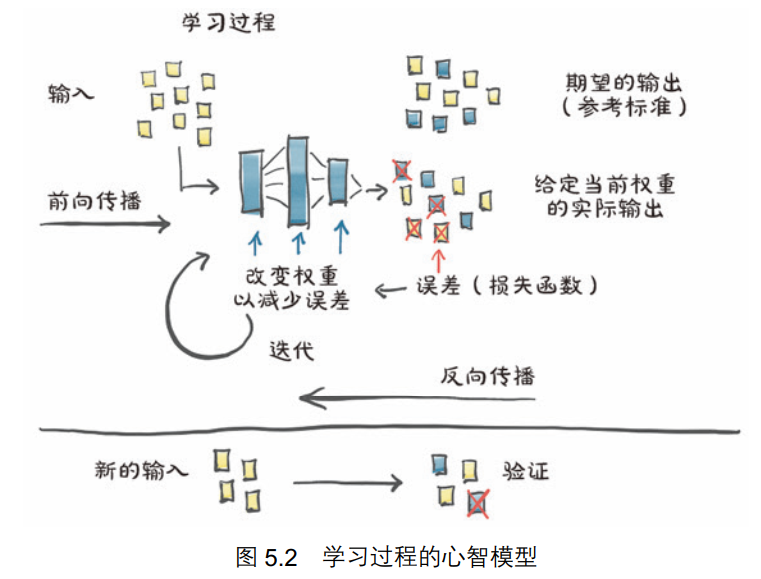

In [77]:
# 将模型写成Python函数
def model(t_u, w, b):
    return w*t_u + b

我们期望 t_u、 w 和 b 分别作为输入张量、权重参数和偏置参数。

In [78]:
# 确定损失函数
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

我们正在构建一个差分张量，先对其平方元素进行处理，最后通过对得到的张量中的所有元素求平均值得到一个标量损失函数，即**均方损失函数**。

我们现在可以初始化参数，调用模型：

In [79]:
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

检查损失的值：

In [80]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

下面介绍一下PyTorch的广播机制：PyTorch 改写了在 NumPy 中流行的广播机制，对大多数二元运算放宽了一些假定条件。它使用以下规则来匹配张量元素。
- 由后向前迭代每个索引维度，如果其一个操作数的维度大小 1，那么 PyTorch 将使用该维度上的单个项与另一个张量沿该维度上的每一项进行运算。
- 如果两个维度大小都大于 1，则它们的维度大小必须相同，并使用自然匹配。
- 如果一个张量的维度大于另一个张量的维度，那么另一个张量上的所有项将和这些维度上的每一项进行运算。
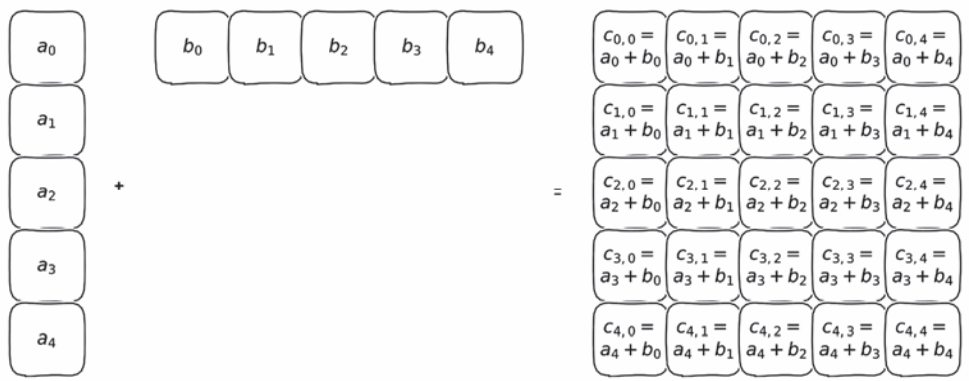

In [81]:
# 广播机制代码示例
x = torch.ones(())
y = torch.ones(3,1)
z = torch.ones(1,3)
a = torch.ones(2,1,1)
print(f"shapes: x: {x.shape}, y: {y.shape}")

print(f"        z: {z.shape}, a: {a.shape}")
print("x * y:", (x * y).shape)
print("y * z:", (y * z).shape)
print("y * z * a:", (y * z * a).shape)

shapes: x: torch.Size([]), y: torch.Size([3, 1])
        z: torch.Size([1, 3]), a: torch.Size([2, 1, 1])
x * y: torch.Size([3, 1])
y * z: torch.Size([3, 3])
y * z * a: torch.Size([2, 3, 3])


**减小损失**

我们可以通过在 w 和 b 上加上一个小数字来估计变化率，然后看看损失在这附近的变化有多大。

In [82]:
delta = 0.1
loss_rate_of_change_w = (
    loss_fn(model(t_u, w + delta, b), t_c) - 
    loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

在 w 和 b 的当前值附近， w 的增加会导致损失的一些变化。如果变化是负的，那么我们需要增加 w 来最小化损失，而如果变化是正的，我们需要减小 w 的值。

In [83]:
learning_rate = 1e-2
w = w - learning_rate * loss_rate_of_change_w

我们可以对 b 采用与 w 相同的处理方式：

In [84]:
loss_rate_of_change_b = (
    loss_fn(model(t_u, w, b + delta), t_c) - 
    loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)
b = b - learning_rate * loss_rate_of_change_w

In [85]:
# 计算导数
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0) # 这个除法来自均值的导数
    return dsq_diffs

def dmodel_dw(t_u, w, b):
    return t_u

def dmodel_db(t_u, w, b):
    return 1

In [86]:
# 定义梯度函数
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

用数学符号表示的相同思想如图 5.7 所示。同样，我们对所有数据点取平均值（求和后除以一个常数），得到损失的每个偏导数的单个标量
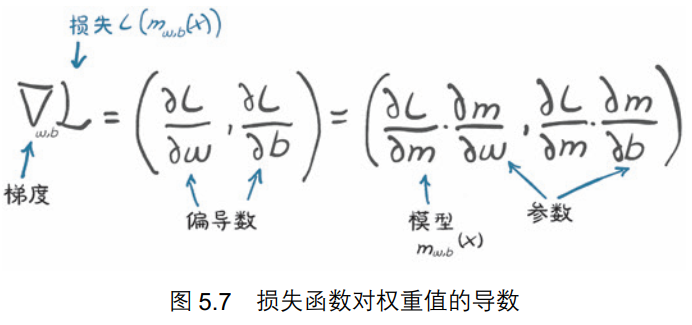

In [87]:
# 循环训练
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params
        # 正向传播
        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        # 反向传播
        grad = grad_fn(t_u, t_c, t_p, w, b)

        params = params - learning_rate * grad
        print('Epoch %d, Loss %f' % (epoch, float(loss)))
    return params

In [88]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c,
                  print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>
            
    return params

In [89]:
# 调用训练循环
training_loop(
    n_epochs = 10,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_u,
    t_c = t_c)

Epoch 1, Loss 1763.884766
    Params: tensor([-44.1730,  -0.8260])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 5802484.500000
    Params: tensor([2568.4011,   45.1637])
    Grad:   tensor([-261257.4062,   -4598.9702])
Epoch 3, Loss 19408029696.000000
    Params: tensor([-148527.7344,   -2616.3931])
    Grad:   tensor([15109614.0000,   266155.6875])
...
Epoch 10, Loss 90901105189019073810297959556841472.000000
    Params: tensor([3.2144e+17, 5.6621e+15])
    Grad:   tensor([-3.2700e+19, -5.7600e+17])


tensor([3.2144e+17, 5.6621e+15])

参数接收到的更新太大了，它们的值开始来回波动，因为每次更新修正过度，就会导致下一次更新更加过度。优化过程是不稳定的：它发散而不是收敛到最小值。我们希望看到参数的更新越来越小，而不是越来越大，如图 5.8 所示。
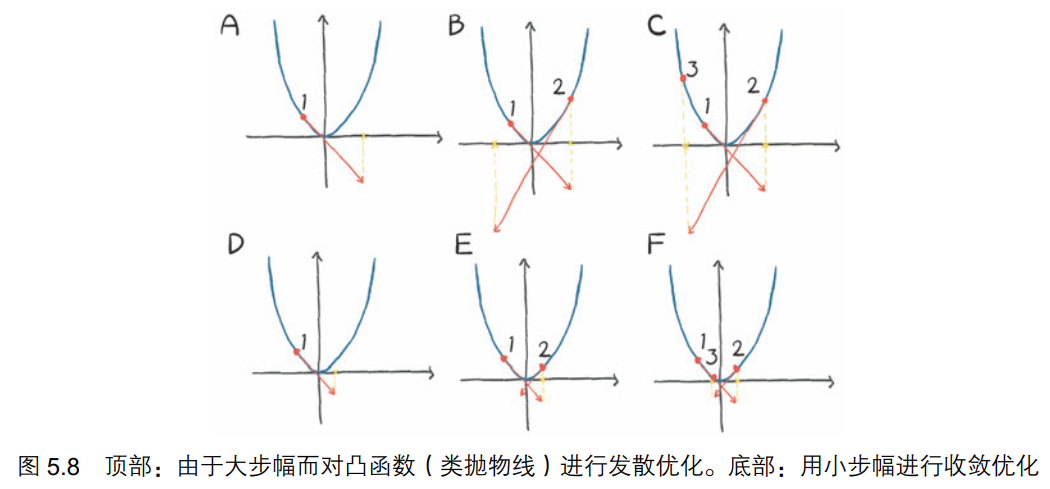

训练进行得不像我们希望的那样好时，我们通常会改变学习率，所以我们可以尝试使用 1e-3 或 1e-4，这会以数量级减少更新的次数。现在我们使用 1e-4，看看它是如何工作的：

In [90]:
training_loop(
    n_epochs = 100,
    learning_rate = 1e-4,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_u,
    t_c = t_c)

Epoch 1, Loss 1763.884766
    Params: tensor([ 0.5483, -0.0083])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 323.090515
    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4666,  16.5122])
...
Epoch 10, Loss 29.105247
    Params: tensor([ 0.2324, -0.0166])
    Grad:   tensor([1.4803, 3.0544])
Epoch 11, Loss 29.104168
    Params: tensor([ 0.2323, -0.0169])
    Grad:   tensor([0.5781, 3.0384])
...
Epoch 99, Loss 29.023582
    Params: tensor([ 0.2327, -0.0435])
    Grad:   tensor([-0.0533,  3.0226])
Epoch 100, Loss 29.022667
    Params: tensor([ 0.2327, -0.0438])
    Grad:   tensor([-0.0532,  3.0226])


tensor([ 0.2327, -0.0438])

现在优化过程已经稳定了，但还有一个问题： 参数接收到的更新非常小，所以损失下降得非常慢，最终停滞不前。我们可以通过学习率自适应来解决这个问题，也就是说，根据更新的大小进行更改。

**归一化输入**

改变输入，这样梯度就不会有太大的不同。粗略地说，我们可以确保输入的范围不会偏离−1.0～1.0 太远。在我们的例子中，我们可以通过简单地将 t_u 乘 0.1 得到一个足够接近的结果：

In [91]:
t_un = 0.1 * t_u

对归一化的输入运行训练循环了：

In [92]:
training_loop(
    n_epochs=100,
    learning_rate=1e-2,
    params=torch.tensor([1.0,0.0]),
    t_u=t_un,
    t_c=t_c
)

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574913
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
...
Epoch 10, Loss 29.030489
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941877
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.214186
    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165])


tensor([ 2.7553, -2.5162])

让我们运行循环进行足够的迭代，以查看参数中的变化是否越来越小。我们将把 n_epochs改为 5000：

In [93]:
params = training_loop(
    n_epochs=5000,
    learning_rate=1e-2,
    params=torch.tensor([1.0,0.0]),
    t_u=t_un,
    t_c=t_c,
    print_params = False
)
params

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574913
Epoch 3, Loss 30.871077
...
Epoch 10, Loss 29.030489
Epoch 11, Loss 28.941877
...
Epoch 99, Loss 22.214186
Epoch 100, Loss 22.148710
...


Epoch 4000, Loss 2.927680
Epoch 5000, Loss 2.927648


tensor([  5.3671, -17.3012])

当我们沿着梯度下降的方向改变参数时，我们的损失减小了。它不会完全趋近于 0，这可能意味着迭代次数不足以使其收敛到 0，或者数据点不完全在一条线上。正如我们预期的那样，我们的测量不是完全准确的，或者读数中有噪声。

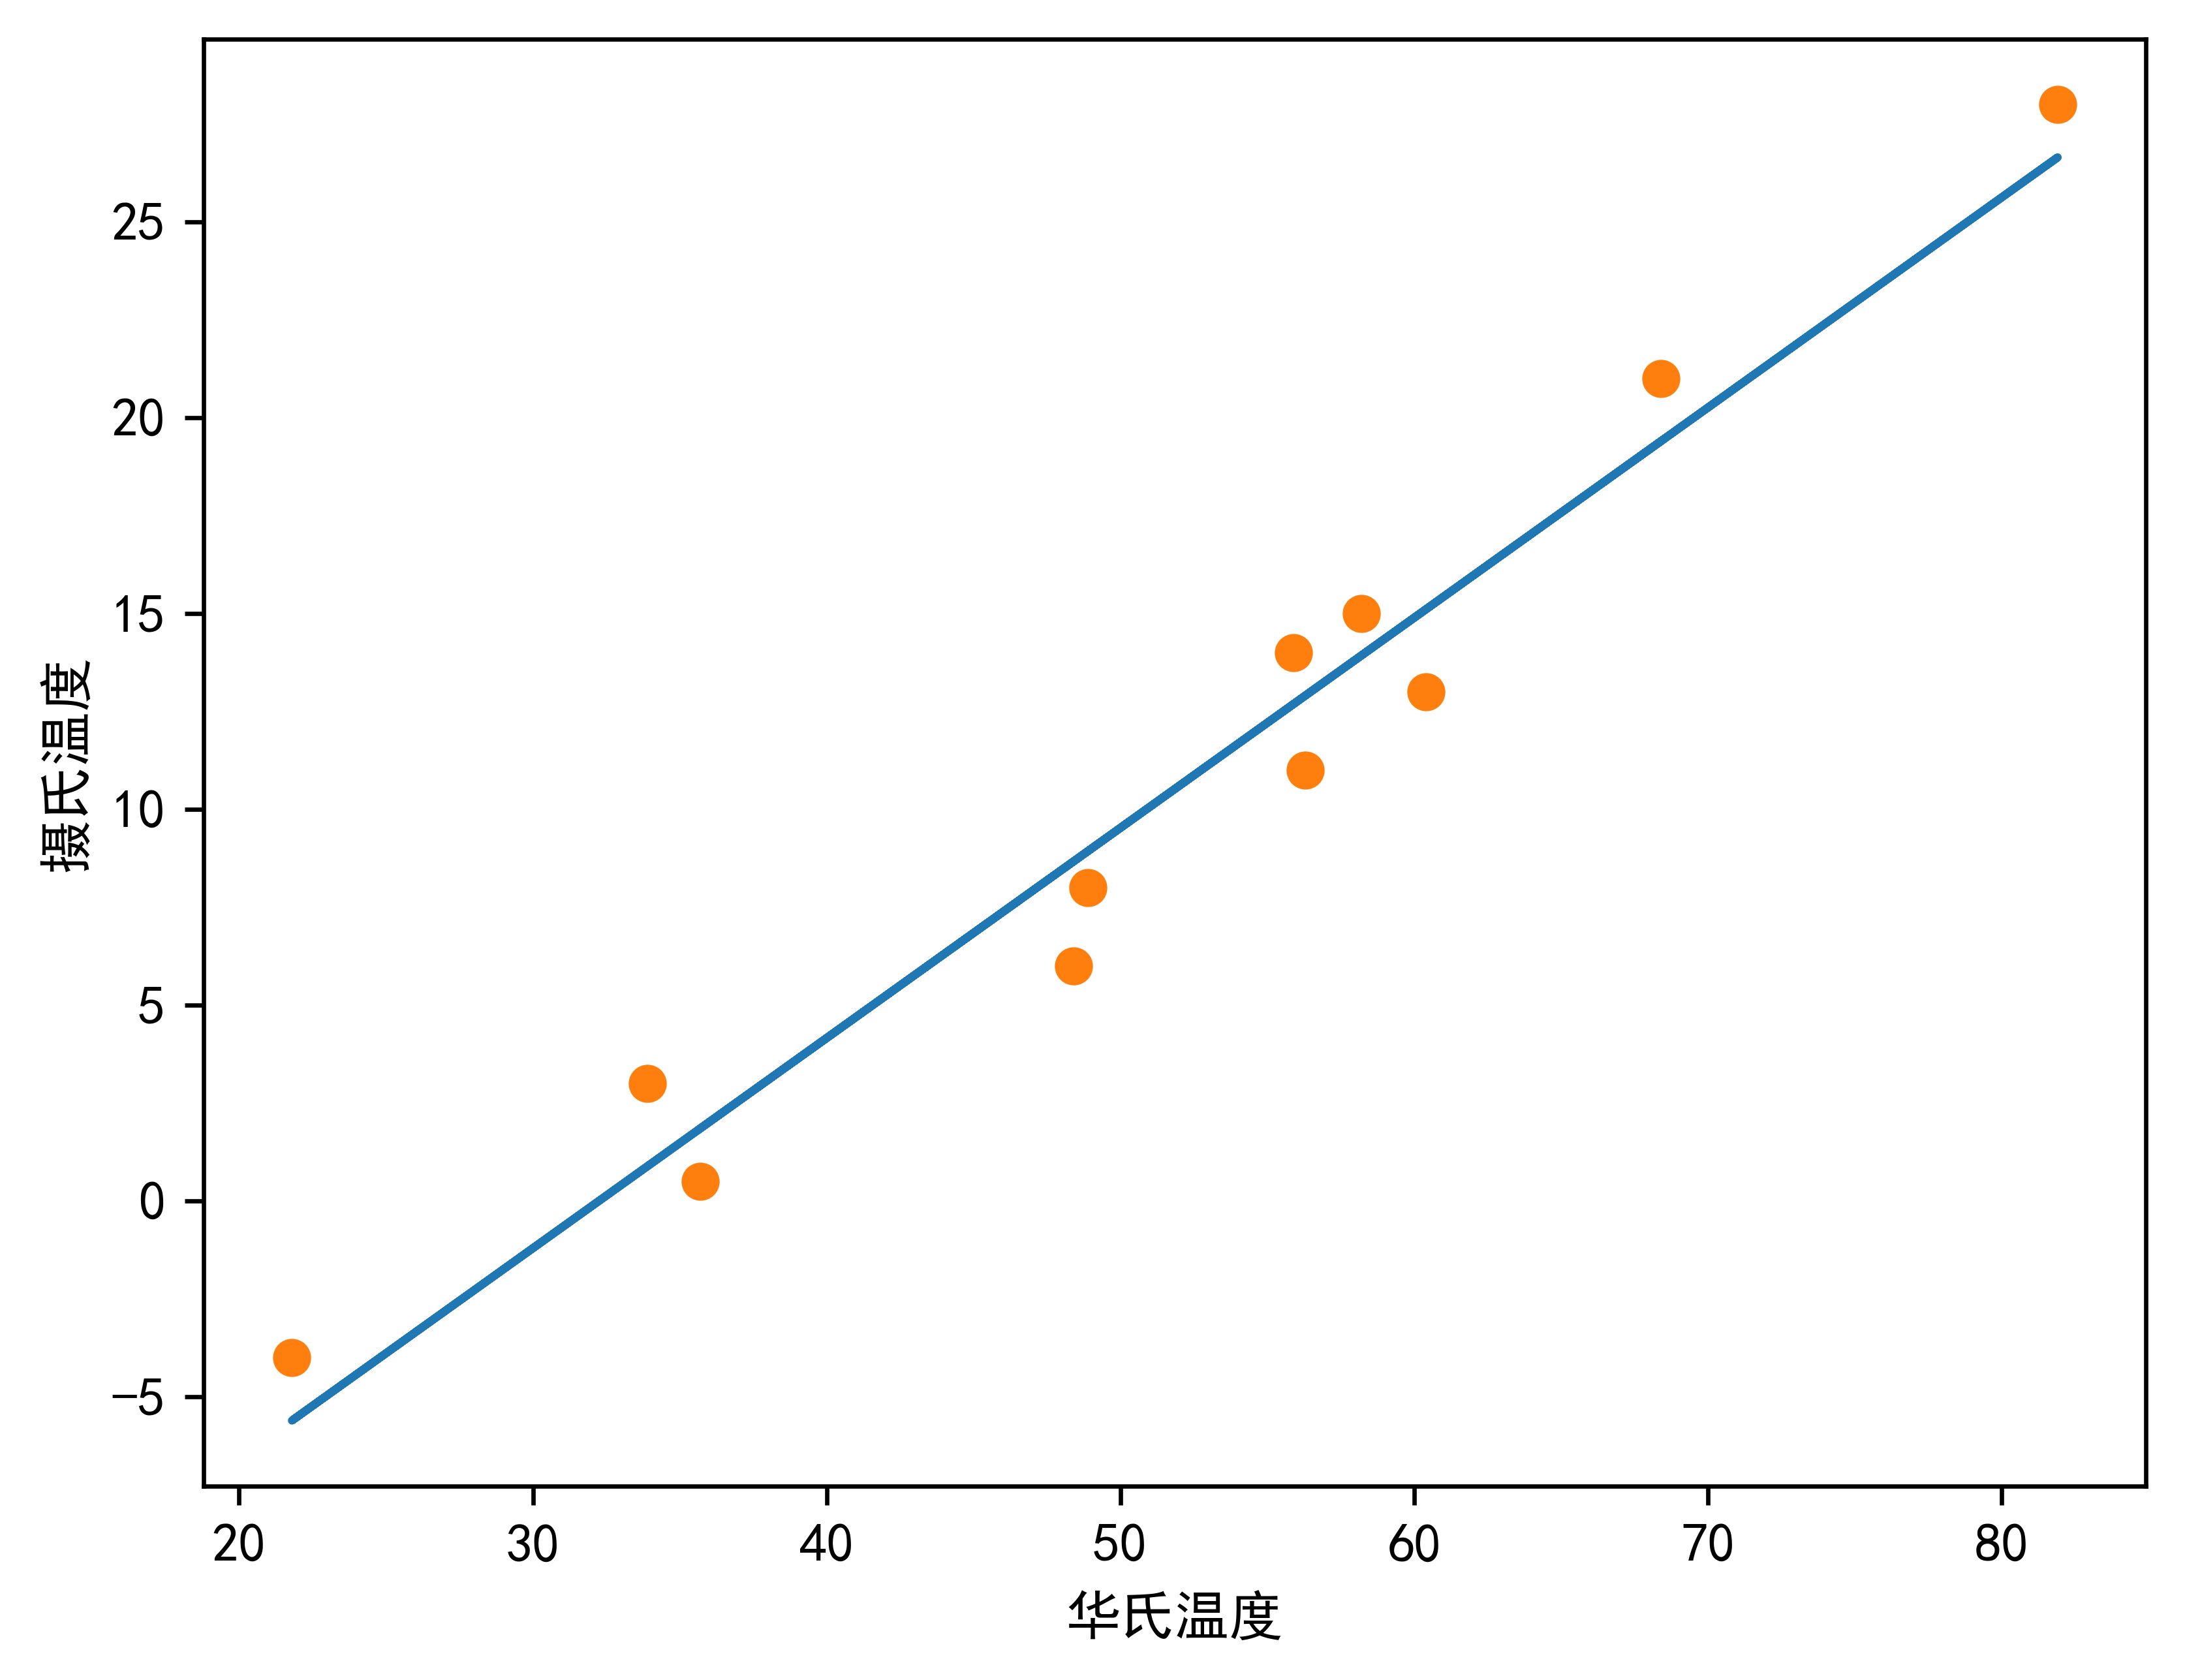

In [94]:
# 再次可视化数据
t_p = model(t_un, *params) # 对归一化的未知部分进行训练
fig = plt.figure(dpi=600)
plt.xlabel("华氏温度")
plt.ylabel("摄氏温度")
"""  
detach()是一个用于从计算图中分离张量的方法。当调用detach()方法时，
它会返回一个新的张量，该张量与原始张量共享相同的数据，但不再与计算图相关联。
换句话说，detach()方法会将张量从计算图中剥离出来，使其成为一个独立的张量。
"""
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

我们在这里使用了一个 Python 技巧，称为参数解包值： `*params` 意味着将 params 的元素作为单独的参数传递。在 Python 中，这通常是通过列表或元组来完成的，但是我们也可以使用PyTorch 张量来进行参数解包，这种参数是沿着前导维度拆分的。这里，`model(t_un,*params)`等价于 `model(t_un,params[0],params[1])`。